In [1]:
# Python
import pandas as pd
from fbprophet import Prophet
import sklearn.metrics
import math

Importing plotly failed. Interactive plots will not work.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import csv
sns.set(rc={'figure.figsize':(11, 4)}, font_scale=1.5)

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/data/')

import make_dataset as ma_da

In [3]:
def load_df_from_datasets(location_prefix, number):
    target_file = "{}_{}.csv".format(location_prefix, number)
    df = pd.read_csv(target_file)
    df = df.rename(columns={'Unnamed: 0':'time'})
    df['time'] = pd.to_datetime(df['time'])
    df['time'] = df['time'].dt.tz_localize(None)
    df['minute'] = df.time.dt.minute + 60 * df.time.dt.hour
    df = df.set_index('time')
    df['year'] = pd.DatetimeIndex(df.index).year
    df['month'] = pd.DatetimeIndex(df.index).month
    df['day'] = pd.DatetimeIndex(df.index).day
    df['hour'] = pd.DatetimeIndex(df.index).hour
    df['minute_of_hour'] = pd.DatetimeIndex(df.index).minute
    df['minute_of_day'] = df['minute_of_hour'] + df['hour'] * 60
    
    
    return df

def preprocess(df, window):
    df_night = ma_da.remove_night_time_data(df)
    df_night_clip = ma_da.remove_clipping_with_flexible_window(df_night, verbose=False)

    df_post = df_night_clip.resample(window).mean()
    df_post["LogPower"] = np.log(df_post["Power"])
    
    return df_post

In [39]:
basic_df = load_df_from_datasets("../data/raw/synthetic_soil/Synthetic_Soil.", 1)    

basic_df_post_daily = preprocess(basic_df, "D")

In [40]:
basic_df_post_daily.head()

,Power,POA,Tamb,Wind,Degradation_rate_per_yr,soiling,minute,year,month,day,hour,minute_of_hour,minute_of_day,LogPower
time,,,,,,,,,,,,,,
2015-01-01,804.930657,322.678832,7.499453,0.0,-0.01114,0.996493,746.5,2015.0,1.0,1.0,11.945255,29.784672,746.5,6.690756
2015-01-02,808.550274,324.760512,7.459781,0.0,-0.01114,0.994182,747.0,2015.0,1.0,2.0,11.954296,29.742230,747.0,6.695243
2015-01-03,809.545620,325.802920,7.417883,0.0,-0.01114,0.991871,747.5,2015.0,1.0,3.0,11.963504,29.689781,747.5,6.696473
2015-01-04,810.792350,326.939891,7.375228,0.0,-0.01114,0.989561,748.0,2015.0,1.0,4.0,11.972678,29.639344,748.0,6.698012
2015-01-05,812.350909,328.225455,7.334909,0.0,-0.01114,0.987250,748.5,2015.0,1.0,5.0,11.981818,29.590909,748.5,6.699932


In [57]:
basic_df_post_daily = basic_df_post_daily.reset_index()
fb_df = basic_df_post_daily[["time", "Power", "soiling"]]
fb_df = fb_df.rename(columns={'time':'ds', 'Power':'y'})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


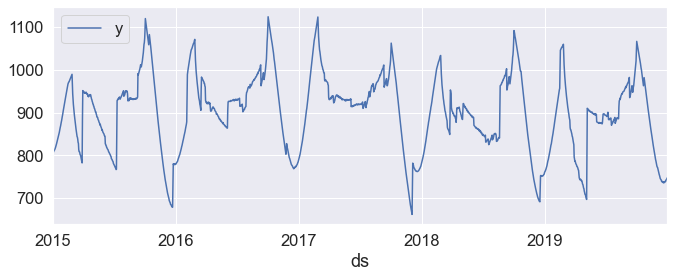

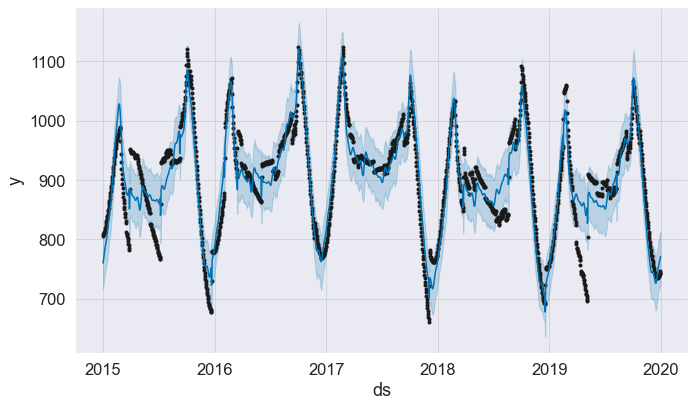

In [105]:
fb_df.plot(y='y', x='ds')
fb_df["soil change"] = new
m = Prophet(yearly_seasonality=30,
            weekly_seasonality=False,
            seasonality_mode='multiplicative',
            growth='linear',
            changepoint_prior_scale=0.05
           )
m.add_regressor('soil change')
m.fit(fb_df)
future = m.make_future_dataframe(2, freq='D')[:-2]
future["soiling"] = fb_df["soiling"]
future["soil change"] = fb_df["soil change"]
forecast = m.predict(future)
fig = m.plot(forecast)

/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


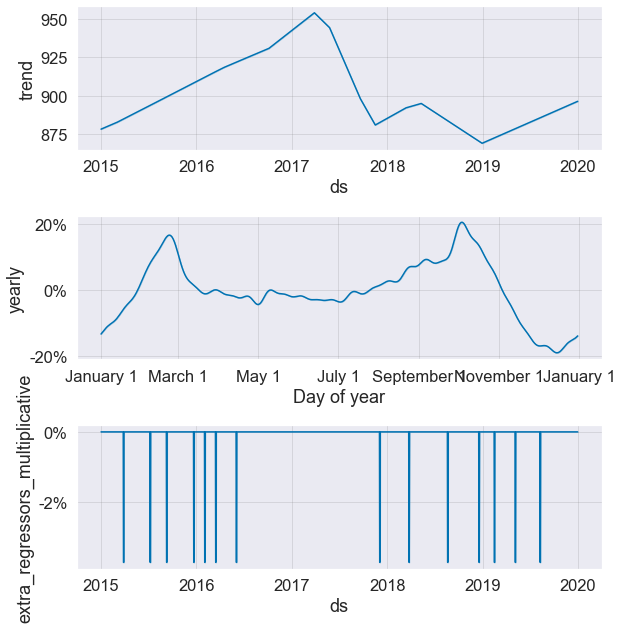

In [106]:
fig2 = m.plot_components(forecast)

In [81]:
trend = forecast.trend.values/forecast.trend.values[0]

In [82]:
from scipy import stats

In [83]:
stats.linregress(x=np.arange(trend.size)/365, y=trend)

LinregressResult(slope=-0.010950584724618021, intercept=0.9966045926550339, rvalue=-0.9854238563545776, pvalue=0.0, stderr=4.4263908394258414e-05)

In [85]:
100*(-0.010950584724618021--0.01114)

0.018941527538197944

In [101]:
ind = np.where(fb_df["soiling"].values[1:] - fb_df["soiling"].values[:-1]> 0.025)

In [102]:
new = np.zeros_like(fb_df["soiling"].values)

In [103]:
new[ind] = 1